In [172]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

import Code.Functions.Figure_Functions as fig_funcs
import py_wave_runup.models as models

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.stats as stats
import netCDF4 as nc
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import os

warnings.filterwarnings("ignore")

# Set paths
DATA_DIR = os.path.join('Data')
FIG_DIR = os.path.join('Figures')

# Figure settings
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use(os.path.join('Code', 'plot_style.mplstyle'))
slope_colors = ['#66c2a5', '#fc8d62', '#8da0cb']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Berm Formation and Presence Introduces Uncertainty into Wave Runup Estimations on Sandy Beaches

Michael Itzkin$^{1}$, Christy Swann$^{2}$, Dallon Weathers$^{2}$, Lauren Tango$^{2}$

$^{1}$Stony Brook University School of Marine and Atmospheric Sciences, Stony Brook, NY

$^{2}$RCoast, Wilmington, NC

**Session:** CP002 – Coastal Geomorphology and Morphodynamics

**Abstract ID:** 2043645

**Poster Number:** CP24B-1580

**Presentation Date:** February 24, 2026 (16:00 - 18:00 GMT)

## Load the Data

Load the morphometrics

In [2]:
morphology_filename = os.path.join(DATA_DIR, 'All Morphometrics Manual.csv')
morpho_df = pd.read_csv(morphology_filename)
morpho_df['beachWidth'] = morpho_df['toeX'] - morpho_df['mhwX']
morpho_df['dryBeachWidth'] = morpho_df['toeX'] - morpho_df['bermX']
morpho_df['wetBeachWidth'] = morpho_df['bermX'] - morpho_df['mhwX']
morpho_df['Date'] = pd.to_datetime(morpho_df['Date'])
morpho_df = morpho_df.sort_values('Date').reset_index(drop=True)
morpho_df.head().round(2)

,Profile,Date,mhwX,mhwY,bermX,bermY,toeX,toeY,crestX,crestY,duneVolume,wetBeachVolume,dryBeachVolume,duneSlope,foreshoreSlope,wetBeachSlope,dryBeachSlope,beachWidth,dryBeachWidth,wetBeachWidth
0,44,2023-03-26,42.75,0.36,57.50,1.48,70.75,2.71,86.25,8.16,50.14,8.44,6.50,0.35,0.08,0.08,0.09,28.00,13.25,14.75
1,25,2023-03-26,39.00,0.35,55.25,1.44,71.00,2.91,83.50,8.57,34.27,8.62,7.96,0.45,0.08,0.07,0.09,32.00,15.75,16.25
2,26,2023-03-26,39.50,0.36,56.25,1.46,71.25,2.88,83.75,8.54,35.83,9.37,7.95,0.45,0.08,0.07,0.09,31.75,15.00,16.75
3,27,2023-03-26,39.75,0.36,55.75,1.45,71.75,3.08,83.50,8.54,32.07,8.71,8.97,0.46,0.09,0.07,0.10,32.00,16.00,16.00
4,28,2023-03-26,40.25,0.37,55.50,1.45,71.25,2.99,84.50,8.49,38.68,8.20,8.36,0.42,0.08,0.07,0.10,31.00,15.75,15.25


The morphology data was pulled from cross-shore transects sampled at a 1 m alongshore spacing and 0.50 m cross-shore resolution.

Load the forcing data:

In [3]:
forcings_filename = os.path.join(DATA_DIR, 'Forcing Data.csv')
forcing_df = pd.read_csv(forcings_filename)
forcing_df['Date'] = pd.to_datetime(forcing_df['Date'])
forcing_df.head()

,Date,Hs,Tp,WD,WindSpeed,WindDir,SWL
0,2023-03-26 00:00:00,1.090,5.720,134.5,15.75,209.0,-0.041
1,2023-03-26 01:00:00,1.105,8.010,131.5,16.52,222.0,0.944
2,2023-03-26 02:00:00,1.120,6.625,136.0,15.36,226.0,1.744
3,2023-03-26 03:00:00,1.050,8.330,130.0,15.94,224.0,1.980
4,2023-03-26 04:00:00,1.040,7.180,131.5,13.22,218.0,1.993


The forcing data includes hourly observations of wind, wave, and tide parameters sampled from the date of the initial survey to the date of the most recent survey.

Make a plot of the forcing data with the survey dates marked off

Figure Saved: Figures/Rex Forcing Data and Survey Timing.png


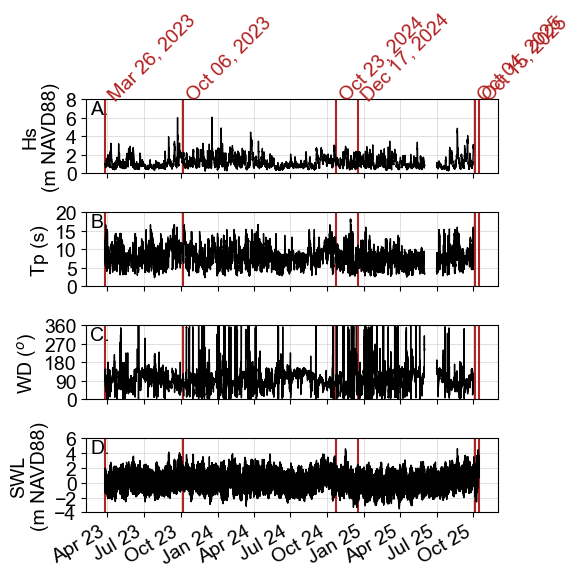

In [4]:
# Set up the figure
fig, axes = plt.subplots(nrows=4, sharex='all', figsize=(6, 6))
fig_funcs.subplot_labels(axes)
survey_color = 'firebrick'

# Plot the forcing data
[ax.plot('Date', why, data=forcing_df, color='black', linewidth=1, zorder=4) for ax, why in zip(axes, ['Hs', 'Tp', 'WD', 'SWL'])]

# Mark the survey dates
for ax in axes:
    [ax.axvline(x=survey_date, color=survey_color, zorder=2) for survey_date in morpho_df['Date'].unique()]
[axes[0].text(x=dd, y=8, s=dd.strftime('%b %d, %Y'), rotation=45, color=survey_color) for dd in morpho_df['Date'].unique()]

# Set the X-Axis
fig.autofmt_xdate()
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

# Set the Y-Axes
[ax.set_ylabel(ll) for ax, ll in zip(axes, ['Hs\n(m NAVD88)', 'Tp (s)', 'WD ($^{o}$)', 'SWL\n(m NAVD88)'])]
[ax.set_ylim(ylim) for ax, ylim in zip(axes, [(0, 8), (0, 20), (0, 360), (-4, 6)])]
axes[0].set_yticks([0, 2, 4, 6, 8])
axes[2].set_yticks([0, 90, 180, 270, 360])

# Save and close the figure
fig_funcs.save_figure(FIG_DIR, 'Rex Forcing Data and Survey Timing', fig=fig)

**Figure XX:** A) Significant wave height (Hs), B) Peak period (Tp), C) Wave direction (WD), and D) Still Water Level (SWL) measured during the study period. The red dates correspond to the timing of lidar surveys. Wave data was sampled from NOAA wave buoy 44100 and tide data was sampled from NOAA tide gauge 8651370; Both at Duck, North Carolina.

## Results

### What is the typical bermed beach morphology?

Before considering runup variability, analyze the typical morphology of a bermed beach at Corolla, NC during the study period and assess the timing of when the berms were present or absent.

In [5]:
morpho_df.columns

Index(['Profile', 'Date', 'mhwX', 'mhwY', 'bermX', 'bermY', 'toeX', 'toeY',
       'crestX', 'crestY', 'duneVolume', 'wetBeachVolume', 'dryBeachVolume',
       'duneSlope', 'foreshoreSlope', 'wetBeachSlope', 'dryBeachSlope',
       'beachWidth', 'dryBeachWidth', 'wetBeachWidth'],
      dtype='object')

Figure Saved: Figures/Bermed Beach Morphology Overview.png


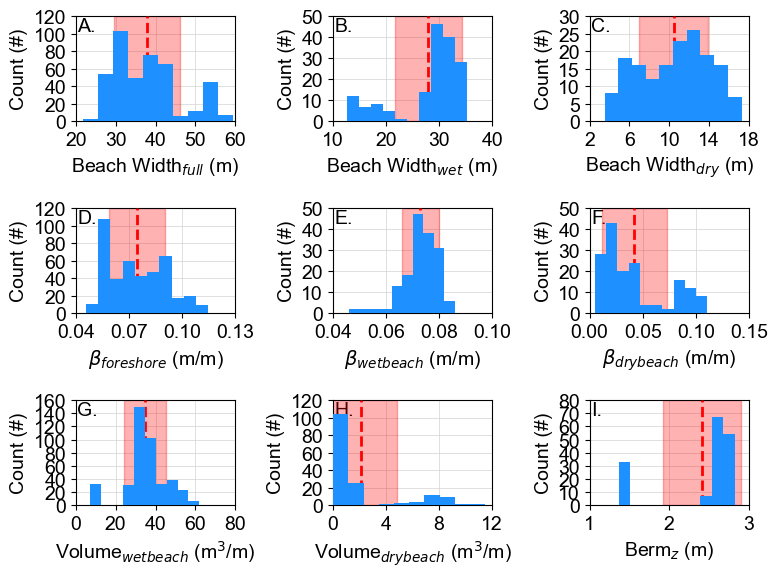

In [6]:
# Set iterables
use_columns = ['beachWidth', 'wetBeachWidth', 'dryBeachWidth',
               'foreshoreSlope', 'wetBeachSlope', 'dryBeachSlope',
               'wetBeachVolume', 'dryBeachVolume', 'bermY']
xlabels = ['Beach Width$_{full}$', 'Beach Width$_{wet}$', 'Beach Width$_{dry}$',
           '$\\beta_{foreshore}$', '$\\beta_{wet beach}$', '$\\beta_{dry beach}$',
           'Volume$_{wet beach}$', 'Volume$_{dry beach}$', 'Berm$_{z}$']
x_units = ['m/m' if 'Slope' in x else 'm$^{3}$/m' if 'Volume' in x else 'm' for x in use_columns]
x_ticks = [np.arange(20, 61, 10), np.arange(10, 41, 10), np.arange(2, 19, 4),
           np.arange(0.04, 0.14, 0.03), np.arange(0.04, 0.11, 0.02), np.arange(0, 0.16, 0.05),
           np.arange(0, 81, 20), np.arange(0, 13, 4), np.arange(1, 3.1, 1)]
y_maxes = [120, 50, 30, 120, 50, 50, 160, 120, 80]

# Set up the figure
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 6))
fig_funcs.subplot_labels(axes)

# Loop over everything
for ax, column, xlabel, xunit, xticks in zip(axes.ravel(), use_columns, xlabels, x_units, x_ticks):

    # Plot the histogram
    ax.hist(column, color='dodgerblue', data=morpho_df, zorder=6)

    # Shade in the mean and standard deviation
    ax.fill_betweenx(y=[0, max(ax.get_yticks())],
                     x1=morpho_df[column].mean() - morpho_df[column].std(),
                     x2=morpho_df[column].mean() + morpho_df[column].std(),
                     color='red',
                     alpha=0.3,
                     zorder=2)
    ax.axvline(x=morpho_df[column].mean(), color='red', linewidth=2, linestyle='--', zorder=4)

    # Set the X-axis
    ax.set_xlim(left=xticks.min(), right=xticks.max())
    ax.set_xticks(xticks)
    ax.set_xlabel(f'{xlabel} ({xunit})')

# Set the Y-Axes
[ax.set_ylim(bottom=0, top=ymax) for ax, ymax in zip(axes.ravel(), y_maxes)]
[ax.set_ylabel('Count (#)') for ax in axes.ravel()]

# Save and close the figure
fig_funcs.save_figure(FIG_DIR, 'Bermed Beach Morphology Overview')

**Figure XX:** Overview of the beach morphology at Corolla for the full study period. Widths of the A) Full, B) Wet, and C) Dry beaches. Slopes ($\\beta$) for the D) foreshore, E) wet beach, and F) dry beach. Volume for the G) wet beach and H) dry beach. I) Berm crest elevation. The dashed red line shows the mean value for each metric and the shaded region shows 1 standard deviation about the mean.

Display key data from the figure above as a table:

In [7]:
morpho_df[use_columns].dropna().describe().round(2)

,beachWidth,wetBeachWidth,dryBeachWidth,foreshoreSlope,wetBeachSlope,dryBeachSlope,wetBeachVolume,dryBeachVolume,bermY
count,161.00,161.00,161.00,161.00,161.00,161.00,161.00,161.00,161.00
mean,38.47,28.02,10.45,0.07,0.07,0.04,27.94,2.10,2.41
std,4.78,6.24,3.44,0.01,0.01,0.03,10.01,2.77,0.49
min,21.75,12.75,3.50,0.06,0.05,0.00,7.06,0.04,1.37
25%,37.00,27.75,7.50,0.06,0.07,0.02,28.18,0.51,2.54
50%,40.00,30.25,11.00,0.07,0.07,0.03,31.58,0.91,2.59
75%,42.00,31.75,13.25,0.07,0.08,0.06,34.45,1.46,2.72
max,45.50,35.25,17.25,0.09,0.09,0.11,39.54,11.49,2.82


When berms were present, the mean beach width was 37.79 $\pm$ 8.32 m. This was split between a wide wet beach ($\mu$ = 28.02 $\pm$ 6.24 m) and a narrow dry beach ($\mu$ = 10.45 $\pm$ 3.44 m). The mean wet beach slope ($\mu$ = 0.07 $\pm$ 0.01 m/m) was generally a good approximation for the mean foreshore slope ($\mu$ = 0.07 $\pm$ 0.01 m/m), while the dry beach was about half as steep ($\mu$ = 0.04 $\pm$ 0.03 m/m). This would suggest good agreement between the Stockdon (2006) equation on bermed beaches based on the beach slope, however the dune toe is set back from the berm and that is not represented in any runup formula.

The most important metric for this poster is the foreshore/wet/dry beach slope. Plot the evolution of these slopes over time to see how they evolve. The mean foreshore and wet beach slopes are the same, but they may differ greatly at any given time.

Figure Saved: Figures/Beach Slope Time Series by Slope Type.png


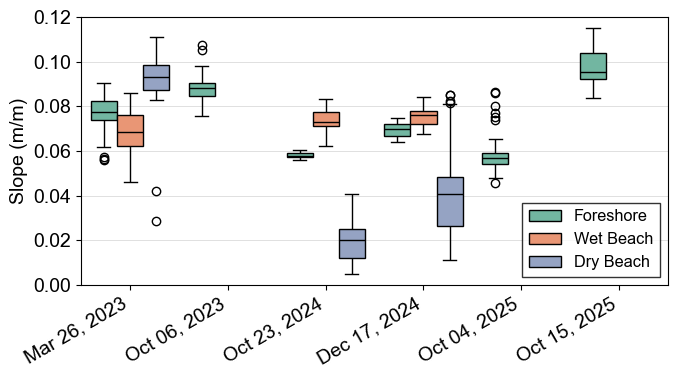

In [8]:
# Make a DataFrame with just the different beach slopes. Melt it down so all the numeric values are in one
# column with a separate column for the data and label
slope_df = pd.melt(morpho_df[['Date', 'foreshoreSlope', 'wetBeachSlope', 'dryBeachSlope']],
                   id_vars=['Date'],
                   value_vars=['foreshoreSlope', 'wetBeachSlope', 'dryBeachSlope'],
                   var_name='Slope Type',
                   value_name='Slope')
slope_df['Slope Type'] = slope_df['Slope Type'].apply(lambda x: 'Foreshore' if 'foreshore' in x else 'Wet Beach' if 'wet' in x else 'Dry Beach')

# Set up the figure
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(x='Date', y='Slope', hue='Slope Type', hue_order=['Foreshore', 'Wet Beach', 'Dry Beach'], palette=slope_colors, linecolor='black', data=slope_df, ax=ax)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='lower right', frameon=True, facecolor='white')
ax.set_xlabel('')
fig.autofmt_xdate()
ax.set_xticklabels(labels=morpho_df['Date'].unique().strftime('%b %d, %Y'))
ax.set_ylim(bottom=0, top=0.12)
ax.set_ylabel('Slope (m/m)')
fig_funcs.save_figure(FIG_DIR, 'Beach Slope Time Series by Slope Type', fig=fig)

**Figure XX:** Boxplot showing the temporal variability of the foreshore slope (green), wet beach slope (orange), and dry beach slope (purple).

Berms were only present on the beach for three of the six surveys; March 26, 2023, October 23, 2024, and December 17, 2024. It is interesting that the dry beach was steeper than the wet beach on March 26, 2023. More importantly, the foreshore slope and wet beach slopes are never really comparable. The foreshore slope was steeper than the wet beach slope on March 26, 2023 but was gentler than the wet beach slope on October 23, 2024 and December 17, 2024.

Perform a series of Kolmogorov-Smirnov tests to see if the foreshore slope and wet beach slope are statistically similar for the individual surveys:

KS-Test ($\alpha$ = 0.05)
H$_{0}$ = The wet beach slope and foreshore slope are the same
H$_{1}$ = The wet beach slope and foreshore slope are not the same

First test the March 26, 2023 data:

In [9]:
test_date = '2023-03-26'
ks_stat, p_value = stats.ks_2samp(slope_df['Slope'].loc[(slope_df['Date'] == test_date) & (slope_df['Slope Type'] == 'Foreshore')],
                                  slope_df['Slope'].loc[(slope_df['Date'] == test_date) & (slope_df['Slope Type'] == 'Wet Beach')],
                                  nan_policy='omit')
if p_value < 0.05:
    print(f'({test_date}) Reject the H0 (p = {p_value:.5f}\tKS-Statistic = {ks_stat:.5f}))')
else:
    print(f'({test_date}) Fail to reject the H0 (p = {p_value:.5f}\tKS-Statistic = {ks_stat:.5f}))')

(2023-03-26) Reject the H0 (p = 0.00019	KS-Statistic = 0.43983))


Now test the October 23, 2024 data:

In [10]:
test_date = '2024-10-23'
ks_stat, p_value = stats.ks_2samp(slope_df['Slope'].loc[(slope_df['Date'] == test_date) & (slope_df['Slope Type'] == 'Foreshore')],
                                  slope_df['Slope'].loc[(slope_df['Date'] == test_date) & (slope_df['Slope Type'] == 'Wet Beach')],
                                  nan_policy='omit')
if p_value < 0.05:
    print(f'({test_date}) Reject the H0 (p = {p_value:.5f}\tKS-Statistic = {ks_stat:.5f}))')
else:
    print(f'({test_date}) Fail to reject the H0 (p = {p_value:.5f}\tKS-Statistic = {ks_stat:.5f}))')

(2024-10-23) Reject the H0 (p = 0.00000	KS-Statistic = 1.00000))


Finally, test the December 17, 2024 data:

In [11]:
test_date = '2024-12-17'
ks_stat, p_value = stats.ks_2samp(slope_df['Slope'].loc[(slope_df['Date'] == test_date) & (slope_df['Slope Type'] == 'Foreshore')],
                                  slope_df['Slope'].loc[(slope_df['Date'] == test_date) & (slope_df['Slope Type'] == 'Wet Beach')],
                                  nan_policy='omit')
if p_value < 0.5:
    print(f'({test_date}) Reject the H0 (p = {p_value:.5f}\tKS-Statistic = {ks_stat:.5f}))')
else:
    print(f'({test_date}) Fail to reject the H0 (p = {p_value:.5f}\tKS-Statistic = {ks_stat:.5f}))')

(2024-12-17) Reject the H0 (p = 0.00000	KS-Statistic = 0.61823))


Despite having the same overall mean value, the wet beach slope and foreshore slopes were significantly different ($\alpha$ = 0.05) for the three surveys where berms were present on the beach. Plot the foreshore slope as a function of the slope difference between the wet and dry beach:

Figure Saved: Figures/Foreshore Slope v Slope Difference.png


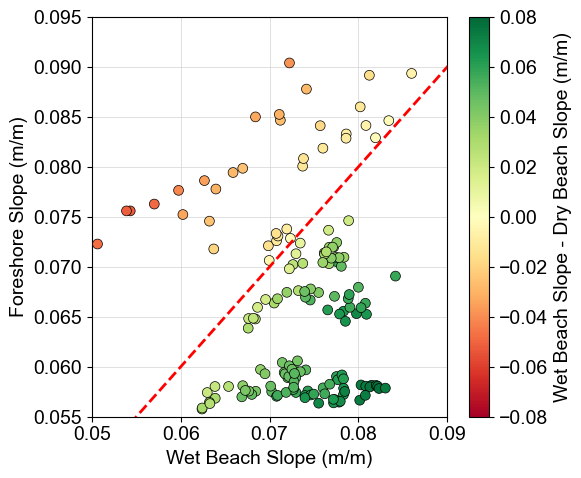

In [12]:
# Set up the figure
fig, ax = plt.subplots(figsize=(6, 5))
pp = ax.scatter(x=morpho_df['wetBeachSlope'],
                y=morpho_df['foreshoreSlope'],
                s=50,
                c=morpho_df['wetBeachSlope'] - morpho_df['dryBeachSlope'],
                vmin=-0.08,
                vmax=0.08,
                cmap='RdYlGn',
                edgecolors='black',
                linewidths=0.5,
                zorder=4)
ax.plot([0, 1], [0, 1], color='red', linewidth=2, linestyle='--', zorder=4)
fig.colorbar(pp, label='Wet Beach Slope - Dry Beach Slope (m/m)', ax=ax)
ax.set_xlim(left=0.050, right=0.090)
ax.set_xticks([0.05, 0.06, 0.07, 0.08, 0.09])
ax.set_xlabel('Wet Beach Slope (m/m)')
ax.set_ylim(bottom=0.055, top=0.095)
ax.set_ylabel('Foreshore Slope (m/m)')
fig_funcs.save_figure(FIG_DIR, 'Foreshore Slope v Slope Difference', fig=fig)

*Figure XX: ** Foreshore slope versus wet beach slope colored by the slope difference between the wet and dry beach. Red (green) points indicate the dry (wet) beach is steeper. The red dashed diagonal line represents 1:1 agreement between the foreshore slope and wet beach slope (i.e., no berm).

### How Does R$_{2\%}$ Estimation Vary Based on Slope Selection?

We've established a significant difference between the wet and dry beach slopes from the "overall" foreshore slope. Now, calculate runup over the course of the study period and analyze how significantly the runup estimations diverge based on choice of slope to use in the formulation.

Calculate the R$_{2\%}$ time series for all profiles and slopes below:

In [13]:
# Set an array of profile numbers
profiles = sorted(morpho_df['Profile'].unique())

# Set an empty DataFrame to put results in
runup_df = pd.DataFrame()

# Loop over the profiles
for profile in profiles:

    # Calculate the runups in a temporary DataFrame
    temp_df = forcing_df.join(morpho_df[['foreshoreSlope', 'wetBeachSlope', 'dryBeachSlope', 'Date']].loc[morpho_df['Profile'] == profile].set_index('Date'), on='Date')
    temp_df = temp_df.ffill()
    temp_df['Foreshore R2'] = models.Stockdon2006(Hs=temp_df['Hs'], Tp=temp_df['Tp'], beta=temp_df['foreshoreSlope']).R2
    temp_df['Wet Beach R2'] = models.Stockdon2006(Hs=temp_df['Hs'], Tp=temp_df['Tp'], beta=temp_df['wetBeachSlope']).R2
    temp_df['Dry Beach R2'] = models.Stockdon2006(Hs=temp_df['Hs'], Tp=temp_df['Tp'], beta=temp_df['dryBeachSlope']).R2

    # Put the runups in the runup_df
    for slope_type in ['Foreshore', 'Wet Beach', 'Dry Beach']:
        runup_df[f'{profile} {slope_type}'] = temp_df[f'{slope_type} R2'].copy()

# Add the dates to the runup df
runup_df['Date'] = temp_df['Date'].copy()

runup_df.head()

,1 Foreshore,1 Wet Beach,1 Dry Beach,2 Foreshore,2 Wet Beach,2 Dry Beach,3 Foreshore,3 Wet Beach,3 Dry Beach,4 Foreshore,...,86 Foreshore,86 Wet Beach,86 Dry Beach,87 Foreshore,87 Wet Beach,87 Dry Beach,88 Foreshore,88 Wet Beach,88 Dry Beach,Date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.516586,NaN,NaN,0.498705,NaN,NaN,0.501889,NaN,NaN,2023-03-26 00:00:00
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.728361,NaN,NaN,0.703150,NaN,NaN,0.707640,NaN,NaN,2023-03-26 01:00:00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.606496,NaN,NaN,0.585503,NaN,NaN,0.589242,NaN,NaN,2023-03-26 02:00:00
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.738368,NaN,NaN,0.712810,NaN,NaN,0.717362,NaN,NaN,2023-03-26 03:00:00
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.633394,NaN,NaN,0.611470,NaN,NaN,0.615375,NaN,NaN,2023-03-26 04:00:00


With all the runups calculated, plot the time series

Figure Saved: Figures/Runup Time Series by Slope.png


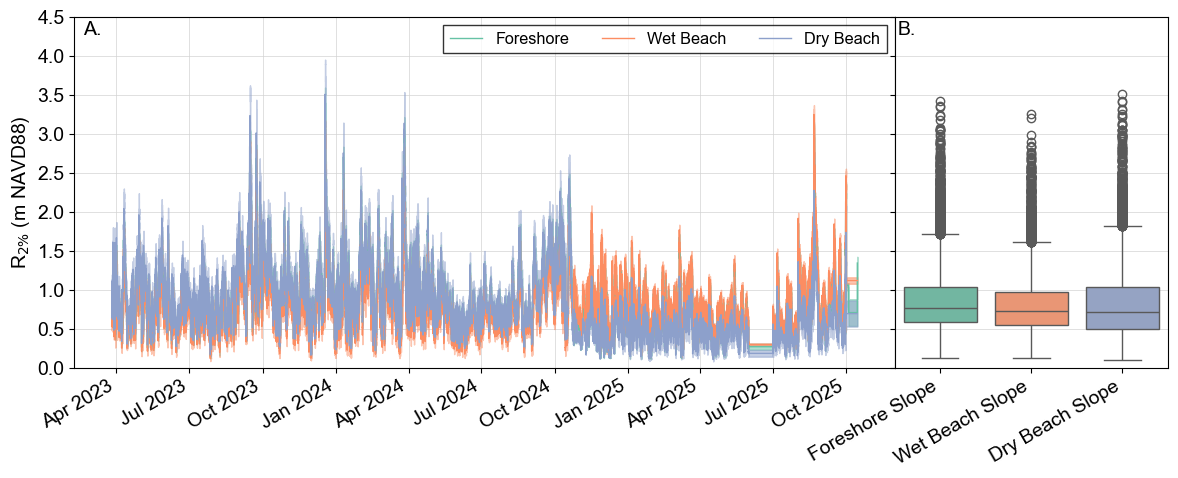

In [14]:
# Set up the figure
fig, axes = plt.subplots(ncols=2, sharey='all', figsize=(12, 5), gridspec_kw={'width_ratios': [3, 1], 'wspace': 0})
fig_funcs.subplot_labels(axes)
sample_interval = '1h'

# Loop over the slopes
boxplot_df = pd.DataFrame()
for slope_type, slope_color in zip(['Foreshore', 'Wet Beach', 'Dry Beach'], slope_colors):

    # Make a plot dataframe
    plot_df = pd.DataFrame()
    plot_df['Mean'] = runup_df[[cc for cc in runup_df.columns if slope_type in cc]].mean(axis=1)
    plot_df['Sd'] = runup_df[[cc for cc in runup_df.columns if slope_type in cc]].std(axis=1)
    plot_df['Lo'] = plot_df['Mean'] - plot_df['Sd']
    plot_df['Hi'] = plot_df['Mean'] + plot_df['Sd']
    plot_df['Date'] = runup_df['Date']

    # Resample the data to make it easier to see
    plot_df = plot_df.set_index('Date').resample(sample_interval).mean().reset_index()

    # Plot the data
    axes[0].fill_between(x='Date', y1='Lo', y2='Hi', color=slope_color, alpha=0.5, data=plot_df, zorder=2)
    axes[0].plot('Date', 'Mean', color=slope_color, linewidth=1, label=slope_type, data=plot_df, zorder=10)

    # Fill in the boxplot dataframe
    boxplot_df[f'{slope_type} Slope'] = plot_df['Mean']

# Make a boxplot of all the runup data on the right panel
sns.boxplot(boxplot_df, palette=slope_colors, ax=axes[1])

# Add a legend
axes[0].legend(loc='upper right', ncol=3)

# Set the X-Axes
fig.autofmt_xdate()
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Set the Y-Axis
axes[0].set_ylim(bottom=0, top=max(axes[0].get_yticks()))
axes[0].set_ylabel('R$_{2\\%}$ (m NAVD88)')

fig_funcs.save_figure(FIG_DIR, 'Runup Time Series by Slope', fig=fig)

**Figure XX:** A) Time series of runup (R$_{2\%}$) estimates over the study period using the foreshore slope (green), wet beach slope (orange), and dry beach slope (purple) as inputs to the Stockdon (2006) equation. B) Boxplot showing the overall distribution of R$_{2\%}$ predictions from each slope.

The runup distributions do not seem to vary much at all based on the slope inputs. Do some statistical tests to compare them. First compare the foreshore slope and wet beach slope for the full period:

In [15]:
p_value, ks_stat = stats.ks_2samp(boxplot_df['Foreshore Slope'], boxplot_df['Wet Beach Slope'], nan_policy='omit')

if p_value < 0.05:
    print(f'(Full Period) Reject the H0 (p = {p_value:.5f}\tKS-Statistic = {ks_stat:.5f}))')
else:
    print(f'(Full Period) Fail to reject the H0 (p = {p_value:.5f}\tKS-Statistic = {ks_stat:.5f}))')

(Full Period) Fail to reject the H0 (p = 0.05906	KS-Statistic = 0.00000))


There is no significant difference between the R$_{2\%}$ values calculated from the wet beach slope or from the dry beach slope. Since there was a significant difference between the slopes between October 23, 2024 and December 17, 2024, do the statistical test with just these dates:

In [16]:
p_value, ks_stat = stats.ks_2samp(boxplot_df['Foreshore Slope'].loc[(runup_df['Date'] >= dt.datetime(2024, 10, 23)) & (runup_df['Date'] <= dt.datetime(2024, 12, 17))],
                                  boxplot_df['Wet Beach Slope'].loc[(runup_df['Date'] >= dt.datetime(2024, 10, 23)) & (runup_df['Date'] <= dt.datetime(2024, 12, 17))],
                                  nan_policy='omit')

if p_value < 0.05:
    print(f'(Fall 2024) Reject the H0 (p = {p_value:.5f}\tKS-Statistic = {ks_stat:.5f}))')
else:
    print(f'(Fall 2024) Fail to reject the H0 (p = {p_value:.5f}\tKS-Statistic = {ks_stat:.5f}))')

(Fall 2024) Fail to reject the H0 (p = 0.18395	KS-Statistic = 0.00000))


Even just focusing on the Fall 2024 data, there is no significant difference between the R$_{2\%}$ values calculated using the wet beach slope and foreshore slope.

To further analyze this, plot a CDF of the different runup values:

Figure Saved: Figures/Runup CDF by Beach Slope.png


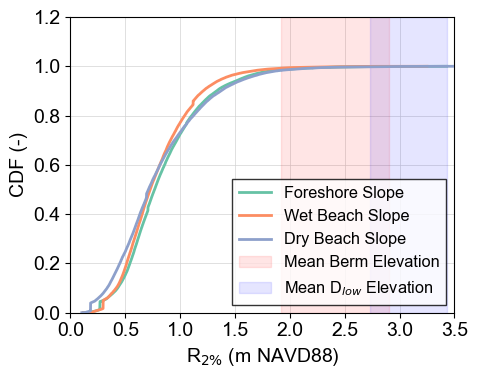

In [17]:
fig, ax = plt.subplots(figsize=(5, 4))
for slope_type, slope_color in zip(['Foreshore', 'Wet Beach', 'Dry Beach'], slope_colors):
    cdf_df = pd.DataFrame()
    cdf_df[f'{slope_type} Slope'] = boxplot_df[f'{slope_type} Slope']
    cdf_df['CDF'] = cdf_df.rank(method='average', pct=True)
    cdf_df = cdf_df.sort_values(by=f'{slope_type} Slope')

    n_impact_hours = cdf_df['CDF'].loc[cdf_df[f'{slope_type} Slope'] > morpho_df['toeY'].mean()].shape[0]
    ax.plot(f'{slope_type} Slope', 'CDF', color=slope_color, linewidth=2, data=cdf_df, label=f'{slope_type} Slope', zorder=10)

ax.fill_betweenx(y=[0, 1.2],
                 x1=morpho_df['bermY'].mean() - morpho_df['bermY'].std(),
                 x2=morpho_df['bermY'].mean() + morpho_df['bermY'].std(),
                 color='red',
                 alpha=0.1,
                 label='Mean Berm Elevation',
                 zorder=2)
ax.fill_betweenx(y=[0, 1.2],
                 x1=morpho_df['toeY'].mean() - morpho_df['toeY'].std(),
                 x2=morpho_df['toeY'].mean() + morpho_df['toeY'].std(),
                 color='blue',
                 alpha=0.1,
                 label='Mean D$_{low}$ Elevation',
                 zorder=2)

ax.legend(loc='lower right')

ax.set_xlim(left=0, right=3.5)
ax.set_xlabel('R$_{2\%}$ (m NAVD88)')

ax.set_ylim(bottom=0, top=1.2)
ax.set_ylabel('CDF (-)')

fig_funcs.save_figure(FIG_DIR, 'Runup CDF by Beach Slope', fig=fig)

**Figure XX:** Cumulative distribution function plots for runup (R$_{2\%}$ calculated using the foreshore (green), wet beach (orange), and dry beach (purple) slopes. The red (blue) shaded area shows the mean ($\pm$ 1 standard deviation) elevation for the beach berm (dune toe).

Even when looking at the CDF, there is not much difference between the three different slope selections. This might make sense since the mean slopes for the full study period did not vary much. As one last point of analysis, look at the mean R$_{2\%}$ value as a function of foreshore slope versus wet beach slope:

In [18]:
morpho_runup_df = morpho_df[['Profile', 'foreshoreSlope', 'wetBeachSlope']]

foreshore_runup_mu, foreshore_runup_sd = [], []
wet_beach_runup_mu, wet_beach_runup_sd = [], []
runup_diff_mu, runup_diff_sd = [], []

for profile in morpho_runup_df['Profile']:
    wet_beach_runup_mu.append(runup_df[f'{profile} Wet Beach'].mean())
    wet_beach_runup_sd.append(runup_df[f'{profile} Wet Beach'].std())
    foreshore_runup_mu.append(runup_df[f'{profile} Foreshore'].mean())
    foreshore_runup_sd.append(runup_df[f'{profile} Foreshore'].std())
    runup_diff_mu.append(np.nanmean(runup_df[f'{profile} Foreshore'] - runup_df[f'{profile} Wet Beach']))
    runup_diff_sd.append(np.nanstd(runup_df[f'{profile} Foreshore'] - runup_df[f'{profile} Wet Beach']))

morpho_runup_df['Foreshore R2 Mean'] = foreshore_runup_mu
morpho_runup_df['Foreshore R2 Sd'] = foreshore_runup_sd
morpho_runup_df['Wet Beach R2 Mean'] = wet_beach_runup_mu
morpho_runup_df['Wet Beach R2 Sd'] = wet_beach_runup_sd
morpho_runup_df['R2 Diff Mean'] = runup_diff_mu
morpho_runup_df['R2 Diff Sd'] = runup_diff_sd
morpho_runup_df['Slope Diff'] = morpho_runup_df['foreshoreSlope'] - morpho_runup_df['wetBeachSlope']

morpho_runup_df.head()

,Profile,foreshoreSlope,wetBeachSlope,Foreshore R2 Mean,Foreshore R2 Sd,Wet Beach R2 Mean,Wet Beach R2 Sd,R2 Diff Mean,R2 Diff Sd,Slope Diff
0,44,0.084123,0.075707,0.844230,0.385007,0.813700,0.352589,0.030529,0.086249,0.008416
1,25,0.079860,0.066983,0.827716,0.369004,0.779326,0.334372,0.048390,0.099302,0.012877
2,26,0.079437,0.065891,0.835547,0.373560,0.775638,0.332398,0.059909,0.110219,0.013545
3,27,0.085004,0.068416,0.867977,0.397390,0.786829,0.337117,0.081148,0.132150,0.016588
4,28,0.084664,0.071218,0.881886,0.406775,0.801125,0.343507,0.080761,0.134625,0.013446


Figure Saved: Figures/Foreshore Slope v Wet Beach Slope v R2 Difference.png


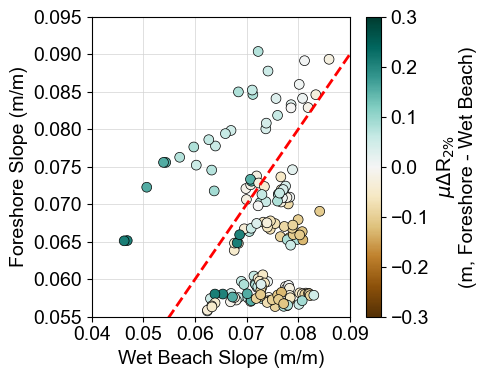

In [19]:
fig, ax = plt.subplots(figsize=(5, 4))
pp = ax.scatter(x='wetBeachSlope', y='foreshoreSlope', c='R2 Diff Mean', cmap='BrBG', vmin=-0.3, vmax=0.3, s=50, edgecolors='black', linewidths=0.5, data=morpho_runup_df, zorder=2)
ax.plot([0, 1], [0, 1], color='red', linewidth=2, linestyle='--', zorder=4)
fig.colorbar(pp, ax=ax, label='$\\mu\\Delta$R$_{2\%}$\n(m, Foreshore - Wet Beach)')
ax.set_xlim(0.04, 0.09)
ax.set_xlabel('Wet Beach Slope (m/m)')
ax.set_ylim(0.055, 0.095)
ax.set_ylabel('Foreshore Slope (m/m)')
fig_funcs.save_figure(FIG_DIR, 'Foreshore Slope v Wet Beach Slope v R2 Difference', fig=fig)

**Figure XX:** Foreshore slope v. wet beach slope colored by the mean difference in runup (R$_{2\%}$) using the foreshore slope minus the wet beach slope. Darker blue (brown) indicates that the foreshore (wet beach) slope produced a larger R$_{2\%}$ prediction. The red dashed line indicates the foreshore slope and wet beach slope were equal (no berm).

Overall, there is a significant amount of variability in the predictions made for R$_{2\%}$ using the different slope types on a profile-by-profile basis however when producing a long-term forecast these differences average out.

### How Does Uncertainty in R$_{\%}$ Vary with Berm Presence?

The last step in this is comparing the runup predictions made using Stockdon (2006) to those produced using XBeach-NH. Since we don't have observed runup values, XB can serve as synthetic "observations." We can then test which beach slope produced the closest estimate.

To do this, a 24-hour simulation was produced using wave data within $\pm$ 12 hours of the timing of the largest waves (December 18, 2023 at 6:00 am). Load the XB input hydrodynamics into a DataFrame:

In [20]:
xb_tides_filename = os.path.join('Modeling', 'Inputs', 'steady_tide.txt')
xb_tides = pd.read_csv(xb_tides_filename, sep=' ', header=None, names=['Timing', 'SWL'])

xb_waves_filename = os.path.join('Modeling', 'Inputs', 'jonswap.txt')
xb_waves = pd.read_csv(xb_waves_filename, sep=' ', header=None, names=['Hs', 'Tp', 'WD', 'Gamma', 'S', 'Duration', 'dtbc'])
xb_waves = xb_waves[['Hs', 'Tp', 'WD']]

xb_df = pd.concat([xb_tides, xb_waves], axis=1)
xb_df['Date'] = pd.date_range(start=dt.datetime(year=2023, month=12, day=18, hour=6) - dt.timedelta(hours=12), freq='H', periods=len(xb_df.index))
xb_df.head()

,Timing,SWL,Hs,Tp,WD,Date
0,0,0.36,1.985,7.705,124.5,2023-12-17 18:00:00
1,3600,0.36,2.030,7.690,123.0,2023-12-17 19:00:00
2,7200,0.36,2.495,7.690,129.0,2023-12-17 20:00:00
3,10800,0.36,2.775,8.515,122.5,2023-12-17 21:00:00
4,14400,0.36,3.210,8.710,123.0,2023-12-17 22:00:00


Re-calculate the profile runups, just in case

In [21]:
for date in morpho_df['Date'].unique():
    use_date = dt.datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S').strftime('%b%d%Y').upper()
    for profile in sorted(morpho_df['Profile'].unique()):

        # Get the slope values to use
        df_filter = (morpho_df['Date'] == date) & (morpho_df['Profile'] == profile)
        use_foreshore = morpho_df['foreshoreSlope'].loc[df_filter]
        use_wet_beach = morpho_df['wetBeachSlope'].loc[df_filter]
        use_dry_beach = morpho_df['dryBeachSlope'].loc[df_filter]

        # Calculate the runups in a temporary DataFrame
        xb_df[f'{use_date}_{profile} Foreshore'] = models.Stockdon2006(Hs=xb_df['Hs'], Tp=xb_df['Tp'], beta=np.repeat(use_foreshore, len(xb_df.index))).R2
        xb_df[f'{use_date}_{profile} Wet Beach'] = models.Stockdon2006(Hs=xb_df['Hs'], Tp=xb_df['Tp'], beta=np.repeat(use_wet_beach, len(xb_df.index))).R2
        xb_df[f'{use_date}_{profile} Dry Beach'] = models.Stockdon2006(Hs=xb_df['Hs'], Tp=xb_df['Tp'], beta=np.repeat(use_dry_beach, len(xb_df.index))).R2

xb_df.head()

,Timing,SWL,Hs,Tp,WD,Date,MAR262023_1 Foreshore,MAR262023_1 Wet Beach,MAR262023_1 Dry Beach,MAR262023_2 Foreshore,...,OCT152025_85 Dry Beach,OCT152025_86 Foreshore,OCT152025_86 Wet Beach,OCT152025_86 Dry Beach,OCT152025_87 Foreshore,OCT152025_87 Wet Beach,OCT152025_87 Dry Beach,OCT152025_88 Foreshore,OCT152025_88 Wet Beach,OCT152025_88 Dry Beach
0,0,0.36,1.985,7.705,124.5,2023-12-17 18:00:00,NaN,NaN,NaN,NaN,...,NaN,1.298160,NaN,NaN,1.288809,NaN,NaN,1.272979,NaN,NaN
1,3600,0.36,2.030,7.690,123.0,2023-12-17 19:00:00,NaN,NaN,NaN,NaN,...,NaN,1.310236,NaN,NaN,1.300799,NaN,NaN,1.284821,NaN,NaN
2,7200,0.36,2.495,7.690,129.0,2023-12-17 20:00:00,NaN,NaN,NaN,NaN,...,NaN,1.452569,NaN,NaN,1.442107,NaN,NaN,1.424393,NaN,NaN
3,10800,0.36,2.775,8.515,122.5,2023-12-17 21:00:00,NaN,NaN,NaN,NaN,...,NaN,1.696256,NaN,NaN,1.684038,NaN,NaN,1.663353,NaN,NaN
4,14400,0.36,3.210,8.710,123.0,2023-12-17 22:00:00,NaN,NaN,NaN,NaN,...,NaN,1.866147,NaN,NaN,1.852706,NaN,NaN,1.829949,NaN,NaN


Now, loop over the XBeach simulations and pull out the R$_{2\%}$ values. This might take some effort since the data output needs to be lined up with the hourly data in the existing dataframe.

**NOTE: Not all simulations ran as of February 19, 2026 so there will be missing data points on the figure**

In [25]:
# Loop over the folders in the 'Modeling' folder, ignore
# anything that doesn't include an XBeach simulation
MODEL_DIR = os.path.join('Modeling')
clear_columns = []
for folder in os.listdir(MODEL_DIR):
        if (folder in ['Bermed Simulation', 'Non-Bermed Simulation', 'Inputs']) or ('.DS' in folder):
            continue
        else:

            # Check that the simulation ran and finished
            if os.path.isfile(os.path.join(MODEL_DIR, folder, 'XBlog.txt')):

                # Open XBlog and see if the simulation finished
                finished_flag = False
                with open(os.path.join(MODEL_DIR, folder, 'XBlog.txt'), 'r+') as f:
                    for line in f:
                        if 'End of program xbeach' in line:
                            finished_flag = True
                            break

                # If the simulation finished run the analysis
                if finished_flag:

                    # Load the XBeach data
                    xb_filename = os.path.join(MODEL_DIR, folder, 'xboutput.nc')
                    with nc.Dataset(xb_filename) as xb_data:
                        water_levels = np.squeeze(xb_data['point_zs'][:])

                    # Loop over the data in hourly chunks and calculate the runup
                    def chunker(seq, size):
                        return (seq[pos: pos + size] for pos in range(0, len(seq), size))
                    r2_hourly = []
                    for hour_group in chunker(water_levels, 3600):
                        try:
                            wl_peaks, locs = signal.find_peaks(hour_group, height=(None, None))
                            r2_hourly.append(np.percentile(locs['peak_heights'], 98))
                        except IndexError:
                            continue
                    r2_hourly.append(np.nanmean(r2_hourly))

                    # Place the runup values in the XBeach dataframe
                    xb_df[f'{folder} XB'] = r2_hourly

                # If the simulation did not finish, skip it. In this case, clean
                # up the XB DataFrame by removing the R2% predictions for that
                # profile/date combination
                else:
                    clear_columns.append(f'{folder} Foreshore')
                    clear_columns.append(f'{folder} Wet Beach')
                    clear_columns.append(f'{folder} Dry Beach')

            else:
                clear_columns.append(f'{folder} Foreshore')
                clear_columns.append(f'{folder} Wet Beach')
                clear_columns.append(f'{folder} Dry Beach')

# Remove the columns associated with model runs that did not finish
xb_df = xb_df.drop(columns=[cc for cc in clear_columns if cc in xb_df.columns])

# Remove empty columns
xb_df = xb_df.T.dropna().T

xb_df.head()

,Timing,SWL,Hs,Tp,WD,Date,MAR262023_7 Foreshore,MAR262023_8 Foreshore,MAR262023_9 Foreshore,MAR262023_16 Foreshore,...,OCT152025_36 XB,OCT152025_31 XB,OCT152025_52 XB,OCT152025_55 XB,OCT152025_63 XB,OCT152025_64 XB,OCT152025_30 XB,DEC172024_12 XB,OCT152025_37 XB,MAR262023_35 XB
0,0,0.36,1.985,7.705,124.5,2023-12-17 18:00:00,0.979481,0.986833,0.987616,1.032818,...,0.600084,0.609738,0.603674,0.578064,0.583741,0.591654,0.557367,0.648937,0.576412,0.600796
1,3600,0.36,2.03,7.69,123.0,2023-12-17 19:00:00,0.988593,0.996014,0.996804,1.042426,...,0.596603,0.594677,0.623907,0.571667,0.619965,0.621366,0.623952,0.676562,0.581094,0.625479
2,7200,0.36,2.495,7.69,129.0,2023-12-17 20:00:00,1.095985,1.104212,1.105088,1.155666,...,0.690293,0.725825,0.695613,0.684568,0.691551,0.70958,0.655758,0.781095,0.735519,0.732139
3,10800,0.36,2.775,8.515,122.5,2023-12-17 21:00:00,1.27985,1.289458,1.29048,1.349543,...,0.750952,0.734923,0.757721,0.788732,0.763614,0.788742,0.723712,0.81078,0.727432,0.800779
4,14400,0.36,3.21,8.71,123.0,2023-12-17 22:00:00,1.408036,1.418605,1.41973,1.484709,...,0.843446,0.887923,0.926698,0.850145,0.89807,0.840311,0.821099,0.980243,0.774503,0.891367


Now with all the XBeach data loaded, make scatterplots showing the R$_{2\%}$ values from each slope type versus XBeach

Figure Saved: Figures/Beach Slope v XB R2.png


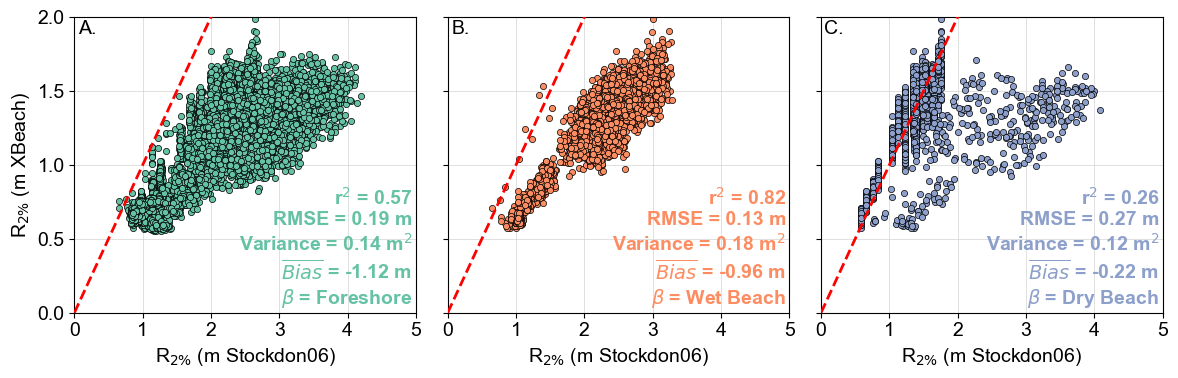

In [56]:
# Set up the figure
fig, axes = plt.subplots(ncols=3, sharey='all', figsize=(12, 4))
fig_funcs.subplot_labels(axes)

# Loop over the slope types
for ax, slope_type, color in zip(axes, ['Foreshore', 'Wet Beach', 'Dry Beach'], slope_colors):

    # Loop over the runup data
    empirical_runup = []
    xb_runup = []
    for column in xb_df.columns:
        if (slope_type in column) and (column.replace(slope_type, 'XB') in xb_df.columns):
            empirical_runup.append(xb_df[column].to_numpy())
            xb_runup.append(xb_df[column.replace(slope_type, 'XB')].to_numpy())
    empirical_runup = np.array(empirical_runup).ravel()
    xb_runup = np.array(xb_runup).ravel()

    # Calculate some statistics
    lm_model = LinearRegression().fit(empirical_runup.reshape(-1, 1), xb_runup.reshape(-1, 1))
    y_true, y_predicted = xb_runup, lm_model.predict(empirical_runup.reshape(-1, 1))
    rtwo_score = r2_score(y_true=y_true, y_pred=y_predicted)
    rmse = root_mean_squared_error(y_true=y_true, y_pred=y_predicted)
    variance = np.nanvar(y_true - y_predicted)
    mean_bias = np.nanmean(xb_runup - empirical_runup)
    stat_str = f'r$^{{2}}$ = {rtwo_score:.2f}\nRMSE = {rmse:.2f} m\nVariance = {variance:.2f} m$^{{2}}$\n$\\overline{{Bias}}$ = {mean_bias:.2f} m'

    # Plot the runups
    ax.scatter(x=empirical_runup, y=xb_runup, color=color, edgecolors='black', linewidths=0.5, zorder=2)

    # Add a 1:1 line for reference
    ax.plot([0, 5], [0, 5], color='red', linewidth=2, linestyle='--', zorder=4)

    # Print the statistics on the panel
    ax.text(x=0.99, y=0.01, s=f'{stat_str}\n$\\beta$ = {slope_type}', color=color, fontweight='bold', transform=ax.transAxes, ha='right', va='bottom', zorder=4)

    # Set the X-Axes
    ax.set_xlim(left=0, right=5)
    ax.set_xlabel(f'R$_{{2\%}}$ (m Stockdon06)')

# Set the Y-Axes
[ax.set_ylim(bottom=0, top=2) for ax in axes]
axes[0].set_ylabel('R$_{2\%}$ (m XBeach)')

fig_funcs.save_figure(FIG_DIR, 'Beach Slope v XB R2', fig=fig)

**Figure XX:** Plot of R$_{2\%}$ calculated from XBeach and the Stockdon (2006) equation using the A) foreshore beach slope, B) wet beach slope, and C) dry beach slope. Statistics descrbing the XBeach versus predicted results are shown. The red dashed line represents 1:1 agreement between the model and predictions.

Finally, plot the difference between the R$_{2\%, foreshore}$ and R$_{2\%, wet beach}$ as a function of foreshore slope versus wet beach slope:

In [199]:
berm_runup_df = pd.DataFrame()
for column in xb_df.columns:
    if ('Foreshore' in column) and (column.replace('Foreshore', 'XB') in xb_df.columns):
        plot_df = pd.DataFrame()
        df_filter = (morpho_df['Date'] == dt.datetime.strptime(column.split(' ')[0].split('_')[0], '%b%d%Y')) & (morpho_df['Profile'] == int(column.split(' ')[0].split('_')[1]))
        plot_df['Foreshore R2'] = xb_df[column].to_numpy()
        plot_df['XB R2'] = xb_df[column.replace('Foreshore', 'XB')].to_numpy()
        plot_df['Foreshore Slope'] = morpho_df['foreshoreSlope'].loc[df_filter].iloc[0]
        plot_df['Wet Beach Slope'] = morpho_df['wetBeachSlope'].loc[df_filter].iloc[0]
        berm_runup_df = pd.concat([berm_runup_df, plot_df])

berm_runup_df['R2 Diff'] = berm_runup_df['XB R2'] - berm_runup_df['Foreshore R2']
berm_runup_df['Slope Diff'] = berm_runup_df['Wet Beach Slope'] - berm_runup_df['Foreshore Slope']

[pd.to_numeric(berm_runup_df[cc]) for cc in berm_runup_df.columns]

berm_runup_df.dropna().head()

,Foreshore R2,XB R2,Foreshore Slope,Wet Beach Slope,R2 Diff,Slope Diff
0,0.857001,0.571886,0.055769,0.062395,-0.285115,0.006626
1,0.864973,0.595238,0.055769,0.062395,-0.269735,0.006626
2,0.958937,0.682078,0.055769,0.062395,-0.276858,0.006626
3,1.11981,0.766487,0.055769,0.062395,-0.353323,0.006626
4,1.231967,0.904344,0.055769,0.062395,-0.327622,0.006626


Figure Saved: Figures/R2 Error v Slope Difference.png


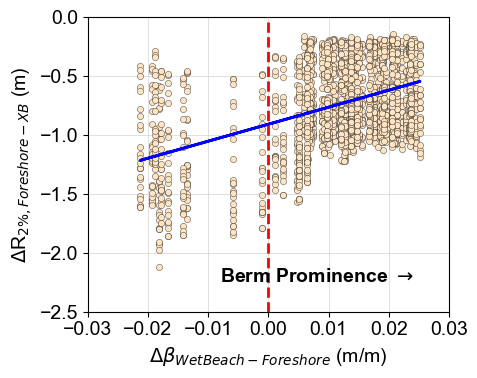

In [200]:
X = berm_runup_df.dropna()['Slope Diff'].to_numpy()
y = berm_runup_df.dropna()['R2 Diff'].to_numpy()
lm = LinearRegression().fit(X.reshape(-1, 1), y.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(x='Slope Diff',
           y='R2 Diff',
           color='bisque',
           edgecolors='black',
           linewidths=0.25,
           data=berm_runup_df,
           zorder=2)
ax.plot(X, lm.predict(X.reshape(-1, 1)), color='blue', linewidth=2, zorder=6)
ax.axvline(x=0, color='red', linewidth=2, linestyle='--', zorder=4)
ax.text(x=-0.008, y=-2.25, s='Berm Prominence $\\rightarrow$', fontweight='bold', zorder=10)
ax.set_xlim(left=-0.03, right=0.03)
ax.set_xlabel('$\Delta\\beta_{Wet Beach - Foreshore}$ (m/m)')
ax.set_ylim(bottom=-2.5, top=0)
ax.set_ylabel('$\Delta$R$_{2\%, Foreshore - XB}$ (m)')
fig_funcs.save_figure(FIG_DIR, 'R2 Error v Slope Difference', fig=fig)

## Methods

Make figures for the methods section of the poster

Plot a profile

Figure Saved: Figures/Example Profile.png


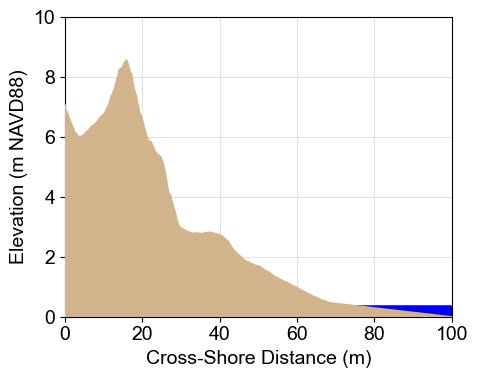

In [237]:
plot_profile = 'DEC172024_60'
X_profile = np.genfromtxt(os.path.join(MODEL_DIR, plot_profile, 'x.txt'), delimiter=' ')
Z_profile = np.genfromtxt(os.path.join(MODEL_DIR, plot_profile, 'z.txt'), delimiter=' ')

X_profile -= X_profile.max()
X_profile = np.abs(X_profile)

fig, ax = plt.subplots(figsize=(5, 4))
ax.fill_between(X_profile, y1=0.36, y2=0, color='blue', zorder=2)
ax.fill_between(X_profile, y1=Z_profile, y2=0, color='tan', zorder=4)
ax.set_xlim(left=0, right=100)
ax.set_xlabel('Cross-Shore Distance (m)')
ax.set_ylim(bottom=0, top=10)
ax.set_ylabel('Elevation (m NAVD88)')
fig_funcs.save_figure(FIG_DIR, 'Example Profile', fig=fig)

Plot the storm time series

Figure Saved: Figures/XBeach Forcings.png


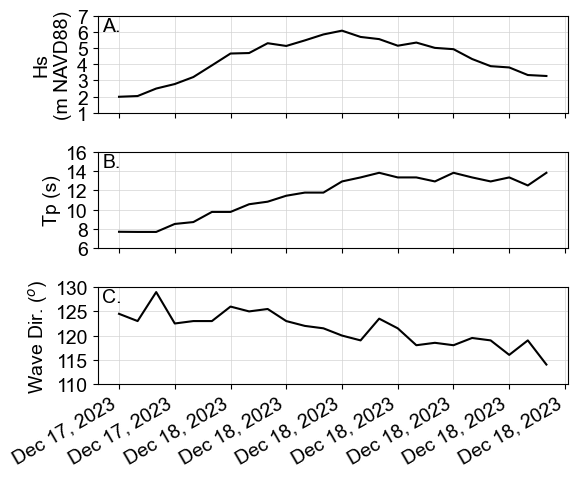

In [256]:
fig, axes = plt.subplots(nrows=3, sharex='all', figsize=(6, 5))
fig_funcs.subplot_labels(axes)
[ax.plot('Date', col, color='black', data=xb_df, zorder=2) for ax, col in zip(axes, ['Hs', 'Tp', 'WD'])]
[ax.set_ylim(ll) for ax, ll in zip(axes, [(1, 7), (6, 16), (110, 130)])]
[ax.set_ylabel(ll) for ax, ll in zip(axes, ['Hs\n(m NAVD88)', 'Tp (s)', 'Wave Dir. ($^{o}$)'])]
fig.autofmt_xdate()
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
fig_funcs.save_figure(FIG_DIR, 'XBeach Forcings', fig=fig)